# ODE

$$
y'=-\lambda xy\\
y(0)=1
$$
Exact solution: $y(x,\lambda)=e^{-\lambda x^2/2}$

[Ref](https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932)


$\lambda-1 \sim Beta(2,2)$, what is the pdf of $y(0.5)$?

In [1]:
import time
import math
import numpy as np
import jax.numpy as jnp
from jax import random
from jax import grad
from jax import vmap
from jax import jit
from scipy.stats import beta
from scipy.stats import norm
from scipy.stats import uniform
from numpy import linalg as LA
from scipy.stats import gaussian_kde as kde

import matplotlib.pyplot as plt
%matplotlib inline

## NN setup


In [2]:
def activate(x):
#     return math.tanh(x)
    return 1./(1. + jnp.exp(-x))

def sol1(x,l):
    return np.exp(-l*x**2/2)

def f1(params, x, l):
    '''Neural network with only one lambda'''
    wx = params[:10]
    wl = params[10:20]
    b0 = params[20:30]
    w1 = params[30:40]
    b1 = params[40]
    x = activate(x*wx + l*wl + b0)
    x = activate(jnp.sum(x*w1) + b1)
    return x
df1dx = grad(f1, 1)  # take the derivative wrt x
f1_vect = vmap(f1,(None,0,0))            # vectorize f, allow vector input x
df1dx_vect = vmap(df1dx, (None, 0, 0))      # vectorize f'

In [3]:
learning_rate = 0.1
momentum = 0.99
ls_epoch = [1000, 2000, 5000, 10000, 20000]

In [4]:
def loss1(params, inputs, lam):
    '''
    Define the loss function from differential equation and boundary condition
    '''
    eq = df1dx_vect(params, inputs,lam) + lam*inputs*f1_vect(params, inputs,lam)    #**
    ic = f1_vect(params, jnp.zeros(len(lam)),lam) - 1.     #***
    return jnp.mean(eq**2) + jnp.mean(ic**2)

grad_loss1 = jit(grad(loss1, 0))     # take the derivative wrt parameter

Nesterov Accelerated Gradient (NAG):

http://proceedings.mlr.press/v28/sutskever13.pdf

$$
v_{t+1} = \mu v_t - \epsilon \nabla f(\theta_t + \mu v_t) \\
\theta_{t+1} = \theta_t + v_{t+1}
$$

In [5]:
key = random.PRNGKey(0) 
params0 = random.uniform(key, shape=(41,))
params1 = random.normal(key, shape=(41,))

In [6]:
def train1(params, inputs, lam, num_epoch):
    velocity = 0.
    for epoch in range(num_epoch):
        gradient = grad_loss1(params + momentum*velocity, inputs, lam)  
        velocity = momentum*velocity - learning_rate*gradient
        params += velocity
    return params

In [7]:
def traindata1(size, **kwargs):
    n = int(np.sqrt(size))
    if 'key' in kwargs.keys():
        key = random.PRNGKey(kwargs['key'])
    else:
        key = random.PRNGKey(0)
    if 'method' in kwargs.keys():
        if kwargs['method'] == 'even':
            xspace = np.linspace(0.3,0.7,n)
            lamspace = np.linspace(1,2,n)
        elif kwargs['method'] == 'uniform':
            xspace = np.linspace(0.3,0.7,n)
            lamspace = random.uniform(key, shape=(n,), minval=1, maxval=2)
        elif kwargs['method'] == 'beta':
            xspace = np.linspace(0.3,0.7,n)
            lamspace = beta.rvs(2, 2, loc=1, scale=1, size=n, random_state=0)
    else:
        xspace = np.linspace(0.3,0.7,n)
        lamspace = np.linspace(1,2,n)
    xx,ll = np.meshgrid(xspace,lamspace)
    a = jnp.array([i for i in zip(xx.ravel(),ll.ravel())])
    inputs = jnp.array(a[:,0])
    lam = jnp.array(a[:,1])
    return inputs, lam

In [8]:
#Training data
inputs1_beta, lam_beta = traindata1(400,method='beta')

## Approximation

### Evaluation at x=0.5

Check the approximation effect of NN with different epochs and initializations ($x$ and $\lambda$) by looking at the evaluation at x=0.5


Since different initializations of params return slightly different params in the end, I put two different initializations of params.

In [9]:
# When the initial params \sim normal
f1eval = {'beta':[]}
params1_mt_beta = np.zeros((len(ls_epoch),len(params1)))
for i in range(len(ls_epoch)):
    params1_mt_beta[i,:] = train1(params1,inputs1_beta,lam_beta,ls_epoch[i])
    val = f1(params1_mt_beta[i,:],0.5,1.1)
    f1eval['beta'].append(val)

### Evaluation on x training interval (0.3,0.7) for fixed $\lambda$

[Return to Contents](#Contents)

In [10]:
pointx = np.linspace(0.3,0.7,101)

evalx_dic = {}
for i in range(len(ls_epoch)):
    evalx_dic[ls_epoch[i]] = [f1(params1_mt_beta[i,:],j,1.1) for j in pointx]
    
evalx_true = jnp.array([sol1(j,1.1) for j in pointx])    

In [11]:
norml = []
for i in ls_epoch:
    diff = [evalx_dic[i][j] - evalx_true[j] for j in range(len(pointx))]
    norml.append(LA.norm(diff,2))
    print('When epochs =' + str(i) + ', the L2 difference of evaluations on (0.3,0.7) is ' + str(norml[-1]))

When epochs =1000, the L2 difference of evaluations on (0.3,0.7) is 0.13084824
When epochs =2000, the L2 difference of evaluations on (0.3,0.7) is 0.09083361
When epochs =5000, the L2 difference of evaluations on (0.3,0.7) is 0.057666995
When epochs =10000, the L2 difference of evaluations on (0.3,0.7) is 0.016817654
When epochs =20000, the L2 difference of evaluations on (0.3,0.7) is 0.014525146


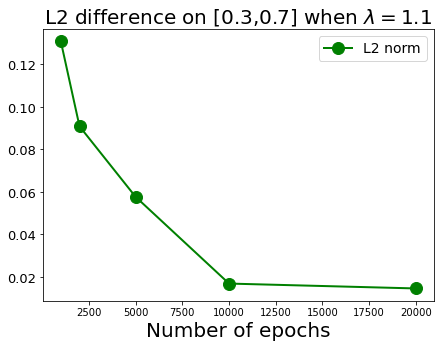

In [12]:
plt.figure(figsize=(7,5))
plt.title('L2 difference on [0.3,0.7] when $\lambda=1.1$',fontsize=20)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=13, rotation=0)
plt.xlabel('Number of epochs',fontsize=20)
plt.plot(ls_epoch,norml,'go-', linewidth=2, markersize=12,label='L2 norm')
plt.legend(prop={'size': 14});
# plt.savefig("images/1.png");

# Forward problem


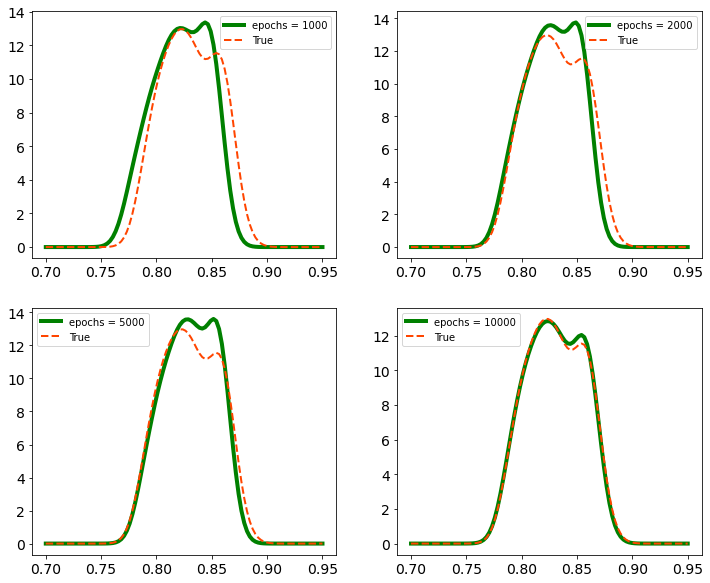

In [13]:
## Truth: \lambda \sim Beta(2,2)
var_lam = beta.rvs(2, 2, loc=1, scale=1, size=100, random_state=0)  ##

eval_ = [0]*len(ls_epoch)
for i in range(len(ls_epoch)):
    eval_[i] = [f1(params1_mt_beta[i,:],0.5,j) for j in var_lam]

eval_true = [sol1(0.5,i) for i in var_lam]
pdf_obs = kde(eval_true)     #True pushforward of beta

plt.figure(figsize=(12,10))
x = np.linspace(0.7,0.95,100)
# plt.suptitle('Push-forward density',fontsize=20)
for i in range(4):
    plt.subplot(2,2,i+1)
#     plt.title('Push-forward density',fontsize=20)
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    pdf_eval = kde(eval_[i])    #approximate pushforward
    plt.plot(x,pdf_eval(x),linewidth=4,color='green',label='epochs = '+str(ls_epoch[i]))
    plt.plot(x,pdf_obs(x),'--',linewidth=2,color='orangered',label='True')
#     plt.xlabel('$\mathcal{D}$',fontsize=10)
    plt.legend(prop={'size': 10});
    
# plt.savefig("images/2.png");

# Inverse Problem

$Q_n$ based on epochs

---
True: beta density

Initial guess: normal density    (uniform is bad, they are not in the same family)


In [14]:
## Normal initial
pdf_true = lambda x: beta.pdf(x, 2, 2, loc=1, scale=1)
   
def Qn(n,l):
    if n == 0:
        val = sol1(0.5,l)
    else:
        upparams = params1_mt_beta[ls_epoch.index(n),:] 
        val = f1(upparams, 0.5, l)   #y(0.5)
    return val   

pdf_init = lambda x: norm.pdf(x, loc=1, scale=1)
samp_init = norm.rvs(loc=1,scale=1,size=1000)  #,random_state=
dic_pf = {}
for epoch in ls_epoch:
    dic_pf[epoch] = [Qn(epoch,j) for j in samp_init]
    
def pdf_pf(n,x):
    if n == 0:
        samp_pf = [Qn(0,j) for j in samp_init]
    else:
        samp_pf = dic_pf[n]
    kde_pf = kde(samp_pf)
    return kde_pf(x)

def pdf_up(n,l):
    nu = pdf_obs(Qn(n,l))
    de = pdf_pf(n,Qn(n,l))
    return pdf_init(l)*nu/de

In [15]:
pointl = np.linspace(1,2,101)

evalup_dic1 = {}   #for L2 norm
evalup_dic2 = {} 
for i in range(len(ls_epoch)):
    evalup_dic1[ls_epoch[i]] = [pdf_up(ls_epoch[i],value) for value in pointl]
    evalup_dic2[ls_epoch[i]] = [pdf_up(ls_epoch[i],value) for value in np.linspace(0.5,2.5,101)]

evalup_true1 = [pdf_true(value) for value in pointl]
evalup_true2 = [pdf_true(value) for value in np.linspace(0.5,2.5,101)]

### L2 difference of updates on (1,2) and (0.5,2.5)

In [16]:
norm1 = []
norm2 = []
for i in ls_epoch:
    diff1 = [evalup_dic1[i][j] - evalup_true1[j] for j in range(len(pointl))]
    norm1.append(LA.norm(diff1,2))
    diff2 = [evalup_dic2[i][j] - evalup_true2[j] for j in range(len(pointl))]
    norm2.append(LA.norm(diff2,2))
#     print('When epochs =' + str(i) + ', the L2 difference on (1,2) is ' + str(norm1[-1]))
#     print('When epochs =' + str(i) + ', the L2 difference on (0.5,2.5) is ' + str(norm2[-1]))

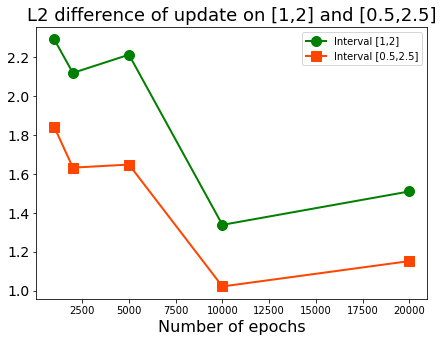

In [17]:
plt.figure(figsize=(7,5))
plt.title('L2 difference of update on [1,2] and [0.5,2.5]',fontsize=18)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Number of epochs',fontsize=16)
plt.plot(ls_epoch,norm1,'go-',linewidth=2,label='Interval [1,2]', markersize=10)
plt.plot(ls_epoch,norm2,'s-',color='orangered',linewidth=2,label='Interval [0.5,2.5]',markersize=10)
plt.legend(prop={'size': 10});
    
# plt.savefig("images/4.png");